# Documentation - Classification

#### Scripts
1. smiles_to_graph.py : SMILES에서 Graph로 변환 (Regression과 동일)
2. class_model.py : GCN 모델 선언
3. class_exp.py : Train & Test
4. classification.py : 모든 과정 진행 (Main)
5. regre_test.py : 학습된 모델로 Test만 진행

#### Packages  
- PyTorch
- PyTorch Geometric (PyG)
- RDKit
- pandas
- numpy
- matplotlib
- sklearn
- time
- argparse
- copy
- warnings
- pickle (Regression과 다름)

### Graph Example

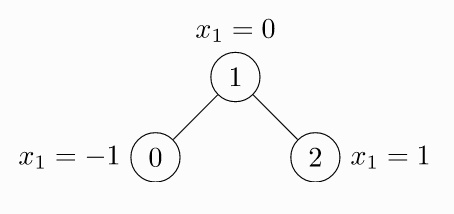

In [1]:
from IPython.display import Image
Image("./images/image01.jpg", width=500, height=200)

- Node : 원
- Node Feature : 0, 1, 2
- Edge : 선
- Edge Feature : -1, 0, 1

In [2]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
data

Data(edge_index=[2, 4], x=[3, 1])

In [3]:
data.edge_index # 0->1, 1->0, 1->2, 2->1

tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])

In [4]:
data.x # Feature Matrix

tensor([[-1.],
        [ 0.],
        [ 1.]])

## 1. smiles_to_graph.py
Molecular Graph 생성

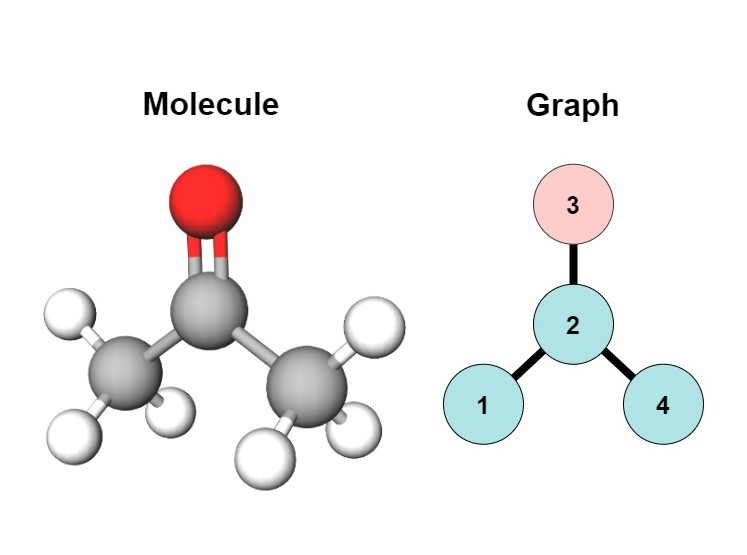

In [5]:
Image("./images/image02.jpg", width=400, height=200)

Molecular Graph에서 Node는 원소, Edge는 결합을 의미한다.

In [6]:
import numpy as np
import torch
from torch_geometric.data import Data
from rdkit import Chem

# One-hot Encoding
def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))

#### 꼭 필요하지 않은 부분 ####
# def get_intervals(l):
#     """For list of lists, gets the cumulative products of the lengths"""
#     intervals = len(l) * [0]
#     # Initalize with 1
#     intervals[0] = 1
#     for k in range(1, len(l)):
#         intervals[k] = (len(l[k]) + 1) * intervals[k - 1]
#     return intervals

# def safe_index(l, e):
#     """Gets the index of e in l, providing an index of len(l) if not found"""
#     try:
#         return l.index(e)
#     except:
#         return len(l)

# possible_atom_list = ['C', 'N', 'O', 'S', 'F', 'P', 'Cl', 'Mg', 'Na', 'Br', 
#                       'Fe', 'Ca', 'Cu', 'Mc', 'Pd', 'Pb', 'K', 'I', 'Al', 'Ni', 'Mn']
# possible_numH_list = [0, 1, 2, 3, 4]
# possible_valence_list = [0, 1, 2, 3, 4, 5, 6]
# possible_formal_charge_list = [-3, -2, -1, 0, 1, 2, 3]
# possible_hybridization_list = [Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
#                                Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D,
#                                Chem.rdchem.HybridizationType.SP3D2]
# possible_number_radical_e_list = [0, 1, 2]
# possible_chirality_list = ['R', 'S']

# reference_lists = [possible_atom_list, possible_numH_list, possible_valence_list,
#                    possible_formal_charge_list, possible_number_radical_e_list,
#                    possible_hybridization_list, possible_chirality_list]
 
# intervals = get_intervals(reference_lists)
 
# def get_feature_list(atom):
#     features = 6 * [0]
#     features[0] = safe_index(possible_atom_list, atom.GetSymbol())
#     features[1] = safe_index(possible_numH_list, atom.GetTotalNumHs())
#     features[2] = safe_index(possible_valence_list, atom.GetImplicitValence())
#     features[3] = safe_index(possible_formal_charge_list, atom.GetFormalCharge())
#     features[4] = safe_index(possible_number_radical_e_list,atom.GetNumRadicalElectrons())
#     features[5] = safe_index(possible_hybridization_list, atom.GetHybridization())
#     return features
 
# def features_to_id(features, intervals):
#     """Convert list of features into index using spacings provided in intervals"""
#     id = 0
#     for k in range(len(intervals)):
#         id += features[k] * intervals[k]
#     # Allow 0 index to correspond to null molecule 1
#     id = id + 1
#     return id

# def id_to_features(id, intervals):
#     features = 6 * [0]
#     # Correct for null
#     id -= 1
#     for k in range(0, 6 - 1):
#         # print(6-k-1, id)
#         features[6 - k - 1] = id // intervals[6 - k - 1]
#         id -= features[6 - k - 1] * intervals[6 - k - 1]
#     # Correct for last one
#     features[0] = id
#     return features
 
# def atom_to_id(atom):
#     """Return a unique id corresponding to the atom type"""
#     features = get_feature_list(atom)
#     return features_to_id(features, intervals)


# Node Feature Matrix 생성
def atom_features(atom,
                  bool_id_feat=False,
                  explicit_H=False,
                  use_chirality=False):
    if bool_id_feat:
        return np.array([atom_to_id(atom)])
    else:
        results = np.array(one_of_k_encoding_unk(atom.GetSymbol(),['C','N','O','S','F','Si','P','Cl','Br','Mg',
                                                                   'Na','Ca','Fe','As','Al','I','B','V','K','Tl',
                                                                   'Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn','H',  # H?
                                                                   'Li','Ge','Cu','Au','Ni','Cd','In','Mn','Zr','Cr',
                                                                   'Pt','Hg','Pb','Unknown']) + 
                           one_of_k_encoding(atom.GetDegree(),[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) + 
                           one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6]) + 
                           [atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + 
                           one_of_k_encoding_unk(atom.GetHybridization(), [Chem.rdchem.HybridizationType.SP, 
                                                                           Chem.rdchem.HybridizationType.SP2, 
                                                                           Chem.rdchem.HybridizationType.SP3, 
                                                                           Chem.rdchem.HybridizationType.SP3D, 
                                                                           Chem.rdchem.HybridizationType.SP3D2]) + 
                           [atom.GetIsAromatic()])
    if not explicit_H:
        results = np.array(results.tolist() + one_of_k_encoding_unk(atom.GetTotalNumHs(),[0, 1, 2, 3, 4]))
    if use_chirality:
        try:
            results = np.array(results.tolist() + 
                               one_of_k_encoding_unk(atom.GetProp('_CIPCode'),['R', 'S']) + 
                               [atom.HasProp('_ChiralityPossible')])
        except:
            results = np.array(results.tolist() + 
                               [False, False] + 
                               [atom.HasProp('_ChiralityPossible')])
 
    return np.array(results)

# Edge Feature Matrix 생성, 실제 연산에서는 쓰이지 않음 #### 꼭 필요하지 않은 부분 ####
def bond_features(bond, use_chirality=False):
    from rdkit import Chem
    bt = bond.GetBondType()
    bond_feats = [bt == Chem.rdchem.BondType.SINGLE, bt == Chem.rdchem.BondType.DOUBLE,
                  bt == Chem.rdchem.BondType.TRIPLE, bt == Chem.rdchem.BondType.AROMATIC,
                  bond.GetIsConjugated(),
                  bond.IsInRing()]
    if use_chirality:
        bond_feats = bond_feats + one_of_k_encoding_unk(str(bond.GetStereo()),
                                                        ["STEREONONE", "STEREOANY", "STEREOZ", "STEREOE"])
    return np.array(bond_feats)

# Edge Index List 생성
def get_bond_pair(mol):
    bonds = mol.GetBonds()
    res = [[],[]]
    for bond in bonds:
        res[0] += [bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]
        res[1] += [bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]
    return res

# Graph 생성
def mol2vec(mol):
    atoms = mol.GetAtoms()
    bonds = mol.GetBonds()
    node_f= [atom_features(atom) for atom in atoms]
    edge_index = get_bond_pair(mol)
    edge_attr = [bond_features(bond, use_chirality=False) for bond in bonds]
    for bond in bonds:
        edge_attr.append(bond_features(bond))
    data = Data(x=torch.tensor(node_f, dtype=torch.float),
                edge_index=torch.tensor(edge_index, dtype=torch.long),
                edge_attr=torch.tensor(edge_attr,dtype=torch.float)) #### 꼭 필요하지 않은 부분 ####
    # edge_attr는 Bond에 대한 Feature이며, 실제 연산에서는 쓰이지 않음
    # data가 Graph에 해당함
    return data

# Solute와 Solvent의 Mol과 logS를 각각 Match
def make_class_mol(df): # Regression과 다름
    mols1_key = []
    mols2_key = []
    mols_value = []
    for i in range(df.shape[0]):
        mols1_key.append(Chem.MolFromSmiles(df['Solute SMILES'].iloc[i]))
        mols2_key.append(Chem.MolFromSmiles(df['Solvent SMILES'].iloc[i]))
        mols_value.append(df['Class'].iloc[i])
    # Solute, Solvent, logS 가 동일한 순서로 담겨있음
    return mols1_key, mols2_key, mols_value

# Graph  최종 생성
def make_class_vec(mols1, mols2, value): # Regression과 다름
    X1 = []
    X2 = []
    Y = []
    for i in range(len(mols1)):
        m1 = mols1[i]
        m2 = mols2[i]
        y = value[i]
        try:
            # Graph 변환이 안되는 경우 제외
            v1 = mol2vec(m1)
            v2 = mol2vec(m2)
            X1.append(v1)
            X2.append(v2)
            Y.append(y)
        except:
            continue
    for i, data in enumerate(X1):
        y = Y[i]
        data.y = torch.tensor([y], dtype=torch.long)
    for i, data in enumerate(X2):
        y = Y[i]
        data.y = torch.tensor([y], dtype=torch.long)
    return X1, X2

#### Example

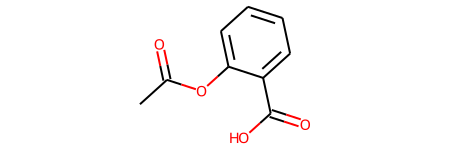

In [7]:
aspirin = 'CC(=O)OC1=CC=CC=C1C(=O)O'
mol = Chem.MolFromSmiles(aspirin)
mol

In [8]:
graph = mol2vec(mol)
graph

Data(edge_attr=[26, 6], edge_index=[2, 26], x=[13, 75])

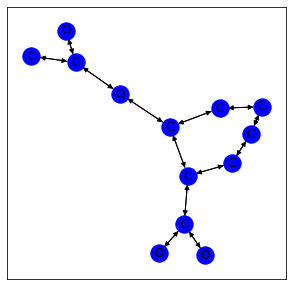

In [9]:
from torch_geometric.utils.convert import to_networkx
import matplotlib.pyplot as plt
import networkx as nx

atoms = mol.GetAtoms()
atom_list = [atom.GetSymbol() for atom in atoms]
labels = {}
for i in range(len(atoms)):
    labels[i] = atom_list[i]
    
G = to_networkx(graph)
pos = nx.spring_layout(G)
plt.rcParams["figure.figsize"] = (5, 5) 
nx.draw_networkx_nodes(G, pos, node_color='blue')
nx.draw_networkx_labels(G, pos, labels, font_size=12)
nx.draw_networkx_edges(G, pos, edge_color='black')
plt.show()

In [10]:
import pandas as pd
# Node Feature Matrix
Node_Feature_Matrix = graph.x
pd.DataFrame(np.array(Node_Feature_Matrix))

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [11]:
# Edge Index
# [0, 1]
# [2, 3]
# 0->2, 1->3으로 연결
Edge_Index = graph.edge_index
pd.DataFrame(np.array(Edge_Index))

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0,1,1,2,1,3,3,4,4,5,...,8,9,9,10,10,11,10,12,9,4
1,1,0,2,1,3,1,4,3,5,4,...,9,8,10,9,11,10,12,10,4,9


In [12]:
from torch_geometric.utils import to_dense_adj
# Edge Index를 Adjacency Matrix로 변환, GCNConv 안에서 이루어짐
Adjacency_Matrix = to_dense_adj(Edge_Index) + np.eye(to_dense_adj(Edge_Index)[0].shape[0])
pd.DataFrame(Adjacency_Matrix[0].numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


In [13]:
# Graph Convolution 개념
Convolution = pd.DataFrame(torch.matmul(Adjacency_Matrix[0].double(), Node_Feature_Matrix.double()).numpy())
# (13, 13) * (13, 75) = (13, 75)
Convolution

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
3,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0
4,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,3.0,3.0,1.0,0.0,0.0,0.0
5,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,3.0,1.0,2.0,0.0,0.0,0.0
6,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0
7,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0
8,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,3.0,1.0,2.0,0.0,0.0,0.0
9,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,3.0,3.0,1.0,0.0,0.0,0.0


## 2. class_model.py
GCN 모델 구현

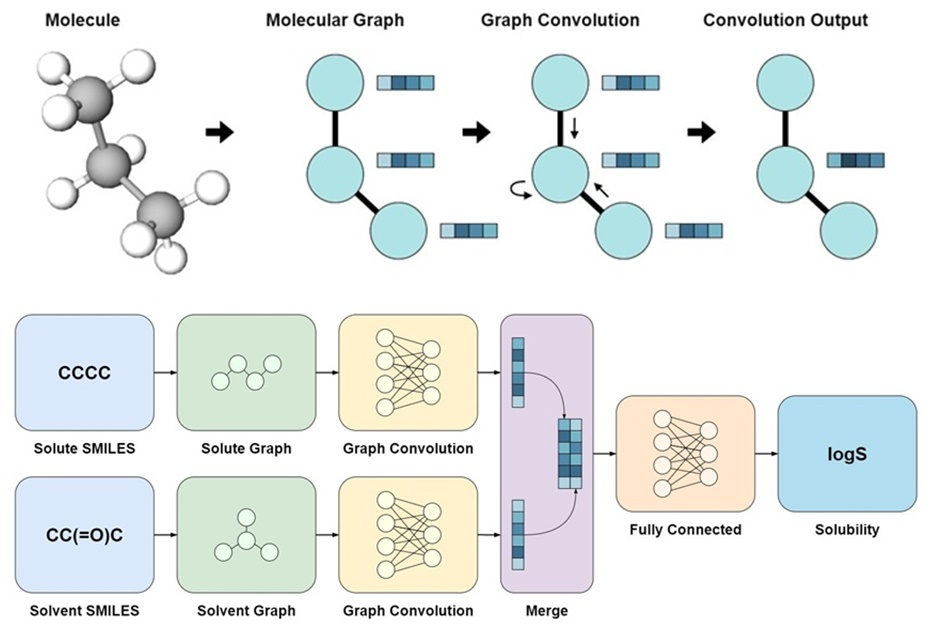

In [14]:
Image("./images/image03.jpg", width=800, height=300)

Graph Convolution Layer는 PyG에서 제공하는 함수인 GCNConv, ARMAConv, SAGEConv를 쓸 수 있습니다. </p>
https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear
from torch.nn import BatchNorm1d
from torch_geometric.nn import GCNConv
from torch_geometric.nn import ARMAConv
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import global_add_pool

# Regression과 다름
n_features = 75
conv_dim1 = 512
conv_dim2 = 512
conv_dim3 = 512
concat_dim = 256
pred_dim1 = 512
pred_dim2 = 512
pred_dim3 = 512
out_dim = 3

class GCNlayer(nn.Module): # 위 그림의 노란색
    def __init__(self, n_features, conv_dim1, conv_dim2, conv_dim3, concat_dim, dropout, conv):
        super(GCNlayer, self).__init__()
        self.n_features = n_features
        self.conv_dim1 = conv_dim1
        self.conv_dim2 = conv_dim2
        self.conv_dim3 = conv_dim3
        self.concat_dim =  concat_dim
        self.dropout = dropout
        self.conv = conv
        
        if self.conv == 'GCNConv':
            self.conv1 = GCNConv(self.n_features, self.conv_dim1, cached=False)
            nn.init.xavier_uniform_(self.conv1.weight)
            self.bn1 = BatchNorm1d(self.conv_dim1)
            self.conv2 = GCNConv(self.conv_dim1, self.conv_dim2, cached=False)
            nn.init.xavier_uniform_(self.conv2.weight)
            self.bn2 = BatchNorm1d(self.conv_dim2)
            self.conv3 = GCNConv(self.conv_dim2, self.conv_dim3, cached=False)
            nn.init.xavier_uniform_(self.conv3.weight)
            self.bn3 = BatchNorm1d(self.conv_dim3)
            self.conv4 = GCNConv(self.conv_dim3, self.concat_dim, cached=False)
            nn.init.xavier_uniform_(self.conv4.weight)
            self.bn4 = BatchNorm1d(self.concat_dim)
            
        elif self.conv == 'ARMAConv':
            self.conv1 = ARMAConv(self.n_features, self.conv_dim1)
            self.bn1 = BatchNorm1d(self.conv_dim1)
            self.conv2 = ARMAConv(self.conv_dim1, self.conv_dim2)
            self.bn2 = BatchNorm1d(self.conv_dim2)
            self.conv3 = ARMAConv(self.conv_dim2, self.conv_dim3)
            self.bn3 = BatchNorm1d(self.conv_dim3)
            self.conv4 = ARMAConv(self.conv_dim3, self.concat_dim)
            self.bn4 = BatchNorm1d(self.concat_dim)
            
        elif self.conv == 'SAGEConv':
            self.conv1 = SAGEConv(self.n_features, self.conv_dim1)
            self.bn1 = BatchNorm1d(self.conv_dim1)
            self.conv2 = SAGEConv(self.conv_dim1, self.conv_dim2)
            self.bn2 = BatchNorm1d(self.conv_dim2)
            self.conv3 = SAGEConv(self.conv_dim2, self.conv_dim3)
            self.bn3 = BatchNorm1d(self.conv_dim3)
            self.conv4 = SAGEConv(self.conv_dim3, self.concat_dim)
            self.bn4 = BatchNorm1d(self.concat_dim)
        
    def forward(self, data, device):
        x, edge_index = data.x.to(device), data.edge_index.to(device)
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.bn3(x)
        x = F.relu(self.conv4(x, edge_index))
        x = self.bn4(x)
        x = global_add_pool(x, data.batch)
        x = F.dropout(x, p=self.dropout, training=self.training)
        return x
    
class FClayer(nn.Module): # 위 그림의 주황색
    def __init__(self, concat_dim, pred_dim1, pred_dim2, pred_dim3, out_dim, dropout):
        super(FClayer, self).__init__()
        self.concat_dim = concat_dim
        self.pred_dim1 = pred_dim1
        self.pred_dim2 = pred_dim2
        self.pred_dim3 = pred_dim3
        self.out_dim = out_dim
        self.dropout = dropout

        self.fc1 = Linear(self.concat_dim*2, self.pred_dim1)
        self.bn1 = BatchNorm1d(self.pred_dim1)
        self.fc2 = Linear(self.pred_dim1, self.pred_dim2)
        self.bn2 = BatchNorm1d(self.pred_dim2)
        self.fc3 = Linear(self.pred_dim2, self.pred_dim3)
        self.fc4 = Linear(self.pred_dim3, self.out_dim)
    
    def forward(self, data):
        x = F.relu(self.fc1(data))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = F.relu(self.fc3(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc4(x)
        return x
    
class Net(nn.Module):
    def __init__(self, args):
        super(Net, self).__init__()
        self.dropout = args.dropout
        self.conv = args.conv
        
        self.conv1 = GCNlayer(n_features, 
                              conv_dim1, 
                              conv_dim2, 
                              conv_dim3, 
                              concat_dim, 
                              self.dropout, 
                              self.conv)
        self.conv2 = GCNlayer(n_features, 
                              conv_dim1, 
                              conv_dim2, 
                              conv_dim3, 
                              concat_dim, 
                              self.dropout, 
                              self.conv)
        self.fc = FClayer(concat_dim, 
                          pred_dim1, 
                          pred_dim2, 
                          pred_dim3, 
                          out_dim, 
                          args.dropout)
        
    def forward(self, solute, solvent, device):
        x1 = self.conv1(solute, device) # Graph Convolution Layer, 위 그림의 노란색
        x2 = self.conv2(solvent, device) # Graph Convolution Layer, 위 그림의 노란색
        x = torch.cat((x1, x2), dim=1) # Merge, 위 그림의 보라색
        x = self.fc(x) # Fully Connected Layer, 위 그림의 주황색
        x = F.log_softmax(x, dim=1) # Regression과 다름
        return x

## 3. class_exp.py
Train & Test

In [16]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
import pickle
from sklearn.metrics import roc_curve, auc

# 모델 저장
def save_checkpoint(epoch, model, optimizer, filename):
    state = {
        'Epoch': epoch,
        'State_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    torch.save(state, filename)

def train(model, device, optimizer, train_loader, criterion, args):
    train_correct = 0
    train_total = 0
    epoch_train_loss = 0
    for i, [solute, solvent] in enumerate(train_loader):
        solute = solute.to(device)
        solvent = solvent.to(device)
        labels = solute.y.to(device)
        optimizer.zero_grad()
        outputs = model(solute, solvent, device)
        outputs.require_grad = False
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        epoch_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    epoch_train_loss /= len(train_loader)
    train_acc =  100 * train_correct / train_total
    print('- Loss : %.4f' % epoch_train_loss)
    print('- Accuracy : %.4f' % train_acc)
    return model, epoch_train_loss, train_acc


def test(model, device, test_loader, args):
    model.eval()
    classes = ('Low', 'Medium', 'High')
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    correct = 0
    total = 0
    nb_classes = len(classes)
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    test_hist = {"test_acc":[]}
    y_score =[]
    y_test =[]
    logS_total = []
    pred_logS_total = []
    roc_total = dict()
    with torch.no_grad():
        for i, [solute, solvent] in enumerate(test_loader):
            solute = solute.to(device)
            solvent = solvent.to(device)
            labels = solute.y.to(device)
            logS_total += solute.y.tolist()
            outputs = model(solute, solvent, device)
            pred_logS_total += outputs.view(-1).tolist()
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            y_score.append(outputs.cpu().numpy())
            y_test.append(labels.cpu().numpy())
            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            for i in range(labels.shape[0]):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_hist["test_acc"].append((predicted == labels).sum().item())
                
    if args.ROC:
        # ROC Curve
        y_test_list = []
        for i in y_test[0]:
            t_list = [0, 0, 0]
            t_list[i] = 1
            y_test_list.append(t_list)
        roc = dict()
        roc['name'] = str(args.exp_name)
        roc['y_score'] = y_score[0].tolist()
        roc['y_test'] = y_test_list
        roc_total[str(args.exp_name)] = roc
        # save data
        with open(args.output_path[:-5]+'.pickle','wb') as fw:
            pickle.dump(roc_total, fw)

    logS_total = list(labels.view(-1).cpu().numpy())
    pred_logS_total = list(predicted.view(-1).cpu().numpy())
    y_pred_list = [a.squeeze().tolist() for a in y_score][0]
    conf = confusion_matrix.tolist()
    total_acc = 100 * correct / total
    low = 100 * class_correct[0] / class_total[0]
    medium = 100 * class_correct[1] / class_total[1]
    high = 100 * class_correct[2] / class_total[2]
    miscore = f1_score(logS_total, pred_logS_total, average='micro')
    mascore = f1_score(logS_total, pred_logS_total, average='macro')
    print()
    print('[Test]')
    print('- Total Accuracy : %d %%' % (100 * correct / total))            
    print('- Accuracy of Low : %2d %%' % (low))
    print('- Accuracy of Medium : %2d %%' % (medium))
    print('- Accuracy of High : %2d %%' % (high))
    print('- F-1 Micro Score : %.2f' % (float(miscore)))
    print('- F-1 Macro Score : %.2f' % (float(mascore)))
    return conf, total_acc, low, medium, high, miscore, mascore, logS_total, pred_logS_total, y_pred_list

# Train & Test & Save Model & Return Results
def experiment(model, train_loader, test_loader, device, args):
    time_start = time.time()
    
    optimizer = optim.Adam(model.parameters(),lr=args.lr)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer,
                                          step_size=args.step_size,
                                          gamma=args.gamma)
    
    list_train_loss = list()
    list_train_acc = list()
    print('[Train]')
    for epoch in range(args.epoch):
        scheduler.step()
        print('- Epoch :', epoch+1)
        model, train_loss, train_acc = train(model, device, optimizer, train_loader, criterion, args)
        list_train_loss.append(train_loss)
        list_train_acc.append(train_acc)
    
    conf, total_acc, low, medium, high, miscore, mascore, logS_total, pred_logS_total, y_pred_list = test(model, device, test_loader, args)
    
    time_end = time.time()
    time_required = time_end - time_start
    
    args.list_train_loss = list_train_loss
    args.list_train_acc = list_train_acc
    args.logS_total = logS_total
    args.pred_logS_total = pred_logS_total
    args.conf = conf
    args.total_acc = total_acc
    args.low = low
    args.medium = medium
    args.high = high
    args.miscore = miscore
    args.mascore = mascore
    args.time_required = time_required
    args.y_pred_list = y_pred_list
    
    save_checkpoint(epoch, model, optimizer, args.model_path)
    
    return args

## 4. classification.py

In [17]:
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import pandas as pd
import argparse
import torch
from torch_geometric.data import DataLoader
from rdkit import Chem
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, auc
import copy
import pickle
import warnings
warnings.filterwarnings(action='ignore')

# 위에서 직접 선언
# from smiles_to_graph import mol2vec
# from smiles_to_graph import make_class_mol
# from smiles_to_graph import make_class_vec
# from class_exp import experiment
# import class_model

In [18]:
# Regression과 다름, Graph로 변환할 수 없는 값이 있는지 확인, Class 값 계산
def make_class(df): # Regression과 다름
    df['Class'] = np.nan
    for i in range(df.shape[0]):
        logs = df['logS'].iloc[i]
        if logs <= -3:
            df['Class'].iloc[i] = 0
        elif logs > -3:
            if logs <= -1:
                df['Class'].iloc[i] = 1
            if logs > -1:
                df['Class'].iloc[i] = 2
    return df

In [19]:
parser = argparse.ArgumentParser()
args = parser.parse_args('')              

# 필요한 Parameter 설정
args.seed=123
args.input_path='../data/data01.xlsx' # 데이터셋 파일명
args.solute_smiles='Solute SMILES' # Solute의 SMILES 값이 담긴 컬럼명
args.solvent_smiles='Solvent SMILES' # Solvent의 SMILES 값이 담긴 컬럼명
args.logS='LogS' # logS 값이 담긴 컬럼명
args.output_path='./results/classification/test_class.json' # 결과 파일을 저장할 경로와 이름
args.model_path='./results/classification/test_class_model.pt' # 모델을 저장할 경로와 이름
args.conv='GCNConv' # Graph Convolution Type 설정 ('GCNConv', 'SAGEConv', 'ARMAConv')
args.test_size=0.2
args.random_state=123
args.batch_size=256
args.epoch=10 # 시간 관계상 10 (Default = 100, Regression과 다름)
args.lr=0.0005 # Regression과 다름
args.step_size=5
args.gamma=0.9
args.dropout=0.1
args.exp_name='myExp'
args.ROC=True # ROC 측정 데이터 저장 여부

In [20]:
np.random.seed(args.seed)
torch.manual_seed(args.seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('- Device :', device)

- Device : cuda


In [21]:
df = pd.read_excel(args.input_path)
df

,Solute SMILES,Solvent SMILES,LogS,Concentration,Class,Solute InChIKey,Solvent InChIKey,Source
0,Cc1c3c(c(c2c1cccc2)C)cccc3,O,-6.570001,2.691530e-07,0,JTGMTYWYUZDRBK-UHFFFAOYSA-N,XLYOFNOQVPJJNP-UHFFFAOYSA-N,ONSC
1,S(=O)(=O)(NC(=O)OC)c1ccc(cc1)N,O,-1.660000,2.187762e-02,1,VGPYEHKOIGNJKV-UHFFFAOYSA-N,XLYOFNOQVPJJNP-UHFFFAOYSA-N,ONSC
2,O=C(CO)[C@@]3(O)CC[C@H]2[C@@H]4CC\C1=C\C(=O)CC...,O(CCOCCOCCO)CCOCCOCCOCCOCCOCCO,-1.660000,2.187762e-02,1,MFYSYFVPBJMHGN-ZPOLXVRWSA-N,YZUUTMGDONTGTN-UHFFFAOYSA-N,ONSC
3,O=C(Nc1ccccc1)N(C)C,CO,-1.659812,2.188709e-02,1,XXOYNJXVWVNOOJ-UHFFFAOYSA-N,OKKJLVBELUTLKV-UHFFFAOYSA-N,ONSC
4,O(C(CCO[N+](=O)[O-])C)[N+](=O)[O-],O,-1.659000,2.192805e-02,1,DGFBULNMARLFTH-UHFFFAOYSA-N,XLYOFNOQVPJJNP-UHFFFAOYSA-N,ONSC
...,...,...,...,...,...,...,...,...
17591,OC(COC1=C2C(C=CC=C2)=CC=C1)CNC(C)C.[H]Cl,CS(C)=O,0.258335,1.812736e+00,2,ZMRUPTIKESYGQW-UHFFFAOYSA-N,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,DMSO
17592,O[C@H]1CC[C@@]2([H])[C@]3([H])CCC4=C(C=CC(OC(C...,CS(C)=O,0.359620,2.288864e+00,2,FKRVEVDSHLGWGC-XRKIENNPSA-N,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,DMSO
17593,O[C@H]1CC[C@@]2([H])[C@]3([H])CCC4=C(C=CC(OC(C...,CS(C)=O,0.435482,2.725728e+00,2,IFDPLCRWEBQEAJ-RBRWEJTLSA-N,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,DMSO
17594,O=C[C@@H]([C@H]([C@@H]([C@@H](CO)O)O)O)O,CS(C)=O,0.476968,2.998944e+00,2,GZCGUPFRVQAUEE-SLPGGIOYSA-N,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,DMSO


In [22]:
# 필요한 값만 남기기
df = pd.concat([df[args.solute_smiles], df[args.solvent_smiles], df[args.logS]], axis=1)
df.columns = ['Solute SMILES', 'Solvent SMILES', 'logS']
df = df.dropna(axis=0).reset_index(drop=True)
df = make_class(df)
df.head()

,Solute SMILES,Solvent SMILES,logS,Class
0,Cc1c3c(c(c2c1cccc2)C)cccc3,O,-6.570001,0.0
1,S(=O)(=O)(NC(=O)OC)c1ccc(cc1)N,O,-1.660000,1.0
2,O=C(CO)[C@@]3(O)CC[C@H]2[C@@H]4CC\C1=C\C(=O)CC...,O(CCOCCOCCO)CCOCCOCCOCCOCCOCCO,-1.660000,1.0
3,O=C(Nc1ccccc1)N(C)C,CO,-1.659812,1.0
4,O(C(CCO[N+](=O)[O-])C)[N+](=O)[O-],O,-1.659000,1.0


In [23]:
# Train Set, Test Set 나누기
X_train, X_test = train_test_split(df, test_size=args.test_size, random_state=args.random_state)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

print(X_train.shape, X_test.shape)
X_train.head() # Train Set과 Test Set 나누기

(14076, 4) (3520, 4)


,Solute SMILES,Solvent SMILES,logS,Class
0,Nc1cccnc1,Cc1ccccc1,-0.027912,2.0
1,O=Cl([O-])=O.O=Cl([O-])=O.[Ca+2],O,0.492587,2.0
2,O=C1OC(Cl)(Cl)C2=C1C=CC(Cl)=C2Cl,O,-5.033232,0.0
3,[N+](=O)([O-])c1ccc(cc1)C,O,-2.490000,1.0
4,CCCCCCCCCC(C)(C)SSC1=NNC(=S)S1,O,-3.988564,0.0


In [24]:
# Regression과 다름 (함수명)
# SMILES를 각각 Graph로 변환하고 Solute, Solvent, Class 세트로 담아서 Data Loader로 만든다.

print('[Converting to Graph]')
# Solute와 Solvent의 SMILES를 Mol로 변환
train_mols1_key, train_mols2_key, train_mols_value = make_class_mol(X_train)
test_mols1_key, test_mols2_key, test_mols_value = make_class_mol(X_test)

# Solute와 Solvent의 Mol을 Graph로 변환
train_X1, train_X2 = make_class_vec(train_mols1_key, train_mols2_key, train_mols_value)
test_X1, test_X2 = make_class_vec(test_mols1_key, test_mols2_key, test_mols_value)

# Solute와 Solvent를 짝으로 List에 담음
train_X = []
for i in range(len(train_X1)):
    train_X.append([train_X1[i], train_X2[i]])
test_X = []
for i in range(len(test_X1)):
    test_X.append([test_X1[i], test_X2[i]])

print('- Train Data :', len(train_X))
print('- Test Data :', len(test_X))

train_loader = DataLoader(train_X, batch_size=args.batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_X, batch_size=len(test_X), shuffle=True, drop_last=True)

[Converting to Graph]
- Train Data : 14076
- Test Data : 3520


In [25]:
# 모델 선언
# model = class_model.Net(args)
model = Net(args) # 위에서 직접 선언
model = model.to(device)

In [26]:
# Train & Test & Save Model & Return Results
dict_result = dict()
result = vars(experiment(model, train_loader, test_loader, device, args))
dict_result[args.exp_name] = copy.deepcopy(result)
result_df = pd.DataFrame(dict_result).transpose()
result_df.to_json(args.output_path, orient='table') # 결과 저장

[Train]
- Epoch : 1
- Loss : 0.7505
- Accuracy : 65.3139
- Epoch : 2
- Loss : 0.6201
- Accuracy : 72.8154
- Epoch : 3
- Loss : 0.5774
- Accuracy : 75.0579
- Epoch : 4
- Loss : 0.5514
- Accuracy : 76.1212
- Epoch : 5
- Loss : 0.5161
- Accuracy : 78.2552
- Epoch : 6
- Loss : 0.4918
- Accuracy : 79.3475
- Epoch : 7
- Loss : 0.4753
- Accuracy : 80.3675
- Epoch : 8
- Loss : 0.4462
- Accuracy : 81.5755
- Epoch : 9
- Loss : 0.4391
- Accuracy : 81.6189
- Epoch : 10
- Loss : 0.4185
- Accuracy : 82.7112

[Test]
- Total Accuracy : 77 %
- Accuracy of Low : 82 %
- Accuracy of Medium : 72 %
- Accuracy of High : 79 %
- F-1 Micro Score : 0.78
- F-1 Macro Score : 0.78


In [27]:
result_df # 저장된 결과

,ROC,batch_size,conf,conv,dropout,epoch,exp_name,gamma,high,input_path,...,pred_logS_total,random_state,seed,solute_smiles,solvent_smiles,step_size,test_size,time_required,total_acc,y_pred_list
myExp,True,256,"[[868.0, 155.0, 26.0], [133.0, 924.0, 222.0], ...",GCNConv,0.1,10,myExp,0.9,79.1107,../data/data01.xlsx,...,"[2, 0, 0, 1, 1, 1, 2, 0, 1, 1, 2, 1, 0, 1, 0, ...",123,123,Solute SMILES,Solvent SMILES,5,0.2,25.2691,77.6989,"[[-7.937271595001221, -1.1608878374099731, -0...."


### Plot
결과 시각화

In [28]:
label_fs = 24
ticks_fs = 18
legend_fs = 14

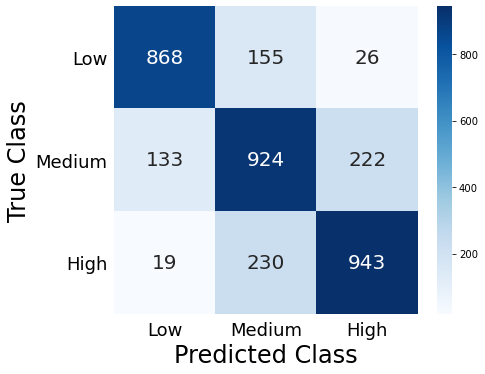

Total Accuracy :  77.7
Accuracy of Low Class :  82.75
Accuracy of Medium Class :  72.24
Accuracy of High Class :  79.11


In [29]:
df = pd.read_json(args.output_path, orient='table')
plt.rcParams["figure.figsize"] = (6, 5)
classes = ('Low', 'Medium', 'High')
c = df['conf'].iloc[0]
confusion_matrix = np.array([c[0], c[1], c[2]], dtype=float)
df_cm = pd.DataFrame(confusion_matrix, range(len(classes)), range(len(classes)))
df_cm = df_cm
sn.heatmap(df_cm.astype('int'), annot=True, cmap='Blues', fmt="d", 
           xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'], annot_kws={"size": 20})
plt.tick_params(left=False, bottom=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.xlabel('Predicted Class', fontsize=label_fs)
plt.ylabel('True Class', fontsize=label_fs)
plt.xticks(fontsize=ticks_fs)
plt.yticks(fontsize=ticks_fs)
plt.yticks(rotation=0)
plt.show()

print('Total Accuracy : ', round(float(result_df['total_acc'].iloc[0]), 2))
print('Accuracy of Low Class : ', round(float(result_df['low'].iloc[0]), 2))
print('Accuracy of Medium Class : ', round(float(result_df['medium'].iloc[0]), 2))
print('Accuracy of High Class : ', round(float(result_df['high'].iloc[0]), 2))

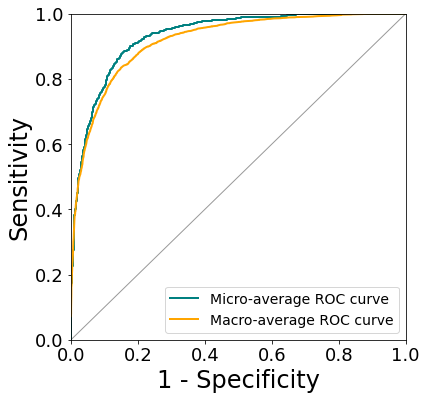

Micro F1-score :  0.93
Macro F1-score :  0.92


In [30]:
with open(str(args.output_path[:-5])+'.pickle', 'rb') as f:
    result_loaded = pickle.load(f)
for i in result_loaded:
    y_test = np.array(result_loaded[i]['y_test'])
    y_score = np.array(result_loaded[i]['y_score'])
    lw = 2
    n_classes = len(classes)
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    plt.rcParams["figure.figsize"] = (6, 6)
    plt.plot(fpr["micro"], tpr["micro"],
             label='Micro-average ROC curve',
             color='teal', linewidth=2)
    plt.plot(fpr["macro"], tpr["macro"],
             label='Macro-average ROC curve',
             color='orange', linewidth=2)
    plt.plot([0, 1], [0, 1], color='black', alpha=0.4, lw=1)
    plt.xlabel('1 - Specificity', size=label_fs)
    plt.ylabel('Sensitivity', size=label_fs)
    plt.xticks(fontsize=ticks_fs)
    plt.yticks(fontsize=ticks_fs)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend(loc="lower right", fontsize=legend_fs)
    plt.show()
    
print('Micro F1-score : ', round(roc_auc["micro"], 2))
print('Macro F1-score : ', round(roc_auc["macro"], 2))

## 5. class_test.py

In [31]:
args.model_path = './results/classification/test_class_model.pt'
args.input_path = './smiles.txt'
args.output_path = './results/classification/myTest.txt'

In [32]:
def test_only(model, device, data_test, args):
    model.eval()
    with torch.no_grad():
        for i, [solute, solvent] in enumerate(test_loader):
            solute = solute.to(device)
            solvent = solvent.to(device)
            output = model(solute, solvent, device)
    return output

# 데이터 불러오기
test_df = pd.read_csv(args.input_path, sep='\t')
test_df['Class'] = 0

# SMILES -> Graph -> Data Loader
test_mols1_key, test_mols2_key, test_mols_value = make_class_mol(test_df)
test_X1, test_X2 = make_class_vec(test_mols1_key, test_mols2_key, test_mols_value)
test_X = []
for i in range(len(test_X1)):
    test_X.append([test_X1[i], test_X2[i]])
test_loader = DataLoader(test_X, batch_size=len(test_X))

# 학습한 모델 불러오기
model = Net(args)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
checkpoint = torch.load(args.model_path)
model.load_state_dict(checkpoint['State_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])

# Test 후에 결과 저장
test_result = test_only(model, device, test_loader, args)
classes = {'0' : 'Low', '1' : 'Medium', '2' : 'High'}
_, test_result = torch.max(test_result, 1)
test_df['Class'] = [classes[str(i)] for i in test_result.cpu().numpy()]
test_df.to_csv(args.output_path, sep='\t', index=False)
print('Done!')

test_df

Done!


,Solute SMILES,Solvent SMILES,Class
0,C=CC(=O)N,O,High
1,C=CC(=O)N,CC(=O)C,High
2,CCCC1=CC=CC=C1,O,Low
3,CCCC1=CC=CC=C1,CC(=O)C,High
